In [1]:
import os
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers, models, losses
from PIL import Image
from custom_data_gen import CustomDataGen
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2024-12-18 00:23:49.046310: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-18 00:23:49.054936: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734477829.064444  402317 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734477829.067273  402317 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-18 00:23:49.077741: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
train = CustomDataGen("/home/shared/Mammiferes_jpg", {"cat": 1.5, "dog": 1.5}, batch_size=8, split="train")
test = CustomDataGen("/home/shared/Mammiferes_jpg", {"cat": 1.5, "dog": 1.5}, batch_size=8, split="test")

{'Chien': 0, 'Castor': 1, 'Ecureuil': 2, 'Renard': 3, 'Puma': 4, 'Lynx': 5, 'Ours': 6, 'Loup': 7, 'Raton_laveur': 8, 'Rat': 9, 'Chat': 10, 'Lapin': 11, 'Coyote': 12}
{'Renard': 0, 'Chien': 1, 'Ecureuil': 2, 'Castor': 3, 'Lynx': 4, 'Ours': 5, 'Puma': 6, 'Loup': 7, 'Raton_laveur': 8, 'Rat': 9, 'Chat': 10, 'Lapin': 11, 'Coyote': 12}


I0000 00:00:1734477830.165390  402317 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 896 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


In [3]:
print(len(train.classes))

13


In [4]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(13, activation='softmax')
])

In [5]:
print(next(iter(train))[0].shape)

(8, 224, 224, 3)


In [6]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

In [7]:
history = model.fit(
    train,
    validation_data=test,
    epochs=20,
)

Epoch 1/20


I0000 00:00:1734477832.578121  402466 service.cc:148] XLA service 0x7f6b94001ca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734477832.578140  402466 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-12-18 00:23:52.596375: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734477832.687246  402466 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-18 00:23:52.724160: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - categorical_accuracy: 0.1250 - loss: 2.6391

I0000 00:00:1734477833.803404  402466 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 6/25 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - categorical_accuracy: 0.1174 - loss: 2.7065

2024-12-18 00:23:54.767371: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 288.53MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - categorical_accuracy: 0.1035 - loss: 2.6726

2024-12-18 00:23:58.281728: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 181.66MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-18 00:23:58.286414: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 308.57MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 234ms/step - categorical_accuracy: 0.1034 - loss: 2.6705 - val_categorical_accuracy: 0.1250 - val_loss: 2.4994
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 194ms/step - categorical_accuracy: 0.1363 - loss: 2.4701 - val_categorical_accuracy: 0.0536 - val_loss: 2.4902
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 207ms/step - categorical_accuracy: 0.1822 - loss: 2.3719 - val_categorical_accuracy: 0.1429 - val_loss: 2.4503
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 208ms/step - categorical_accuracy: 0.0940 - loss: 2.3817 - val_categorical_accuracy: 0.1786 - val_loss: 2.4205
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - categorical_accuracy: 0.2116 - loss: 2.3132 - val_categorical_accuracy: 0.1607 - val_loss: 2.3875
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - categorical_accuracy: 0.1770 - loss: 2.3055 - val_categorical_accuracy: 0.1071 - val_loss: 2.4681
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 204ms/step - categorical_accuracy: 0.1415 - loss: 2.2877 -

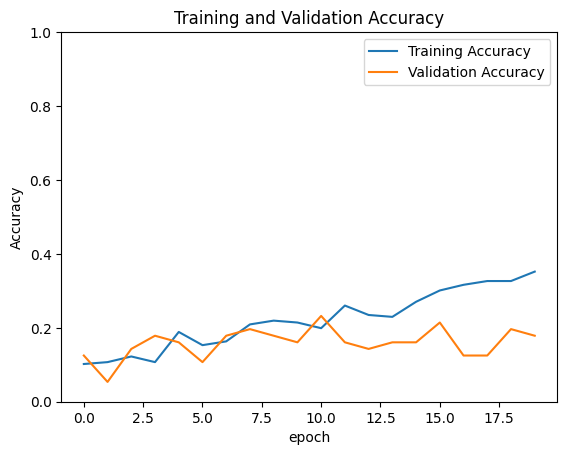

Text(0.5, 0, 'epoch')

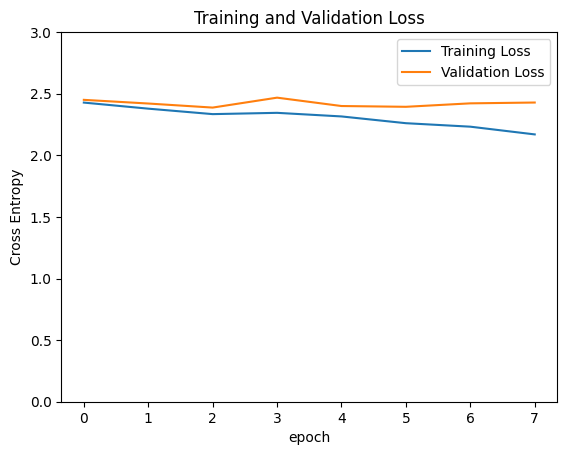

In [8]:
plt.plot(history.history["categorical_accuracy"], label='Training Accuracy')
plt.plot(history.history["val_categorical_accuracy"], label='Validation Accuracy')
plt.legend(loc='best')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')
plt.show()

plt.plot(history.history["loss"][2:10], label='Training Loss')
plt.plot(history.history["val_loss"][2:10], label='Validation Loss')
plt.legend(loc='best')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

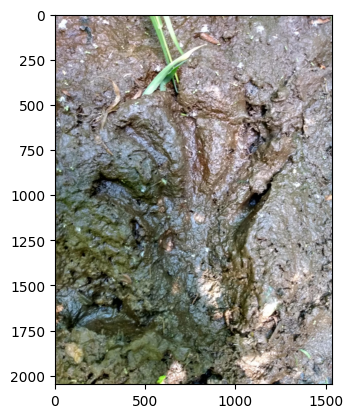

In [9]:
plt.imshow(Image.open("/home/shared/Mammiferes_jpg/Castor/original.jpeg"))

In [10]:
castor = tf.io.read_file("/home/shared/Mammiferes_jpg/Castor/original.jpeg")
castor = tf.image.decode_jpeg(castor, channels=3)
resized_castor = tf.image.resize(castor, [256,256], method="bilinear")

In [11]:
input = tf.expand_dims(
    resized_castor,
    axis = 0
)

In [12]:
input.shape

TensorShape([1, 256, 256, 3])

In [13]:
model.predict(input)

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 86528, but received input with shape (1, 115200)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1, 256, 256, 3), dtype=float32)
  • training=False
  • mask=None

In [ ]:
next(iter(test))[0].shape

In [ ]:
class_names = train.classes
print(class_names)

In [ ]:
plt.figure(figsize=(10, 10))
batch,_ = test.take(3)
plt.imshow(batch[0][1].numpy().astype("uint8"))
plt.title(class_names[batch[1][1]])
plt.axis("off")
